In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.signal as sgn
from scipy.optimize import minimize
from matplotlib.patches import Rectangle

In [19]:
save_arr_dir = 'C:/Users/Kazim/Desktop/Overall/VignettingCircleDetection/savedarrays/091123_ellipse_cv2_fit_tiff_size/'
center_cords = np.loadtxt(save_arr_dir+'center.txt').reshape([7, 7, 2])

In [130]:
origin = center_cords[3, 3]
y_unit = center_cords[3, 2][1] - origin[1] 
x_unit = center_cords[4, 3][0] - origin[0]

origin, y_unit, x_unit

x_axis = [origin[0] - i*x_unit for i in range(-3, 4)]
y_axis = [origin[1] - i*y_unit for i in range(-3, 4)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T

undistorted_points = np.zeros_like(center_cords)
undistorted_points[:, :, 0] = xx
undistorted_points[:, :, 1] = yy

undistorted_points = (undistorted_points - origin).reshape([-1, 2]) # shift grids center to (0, 0)
distorted_points = (center_cords - origin).reshape([-1, 2])

undistorted_points = np.delete(undistorted_points, [0, 6, -7, -1], axis=0)
distorted_points = np.delete(distorted_points, [0, 6, -7, -1], axis=0)

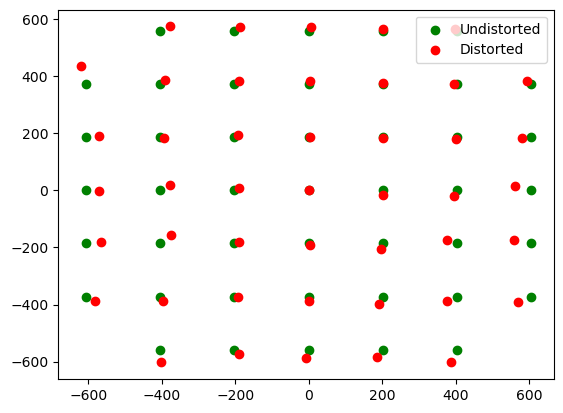

In [131]:
plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='green', label='Undistorted')
plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red', label='Distorted')
plt.legend()

In [132]:
r_ud = np.sqrt((undistorted_points[:, 0])**2  + (undistorted_points[:, 1])**2)
theta_ud = np.arctan2(undistorted_points[:, 1], undistorted_points[:, 0])

r = np.sqrt((distorted_points[:, 0])**2  + (distorted_points[:, 1])**2).reshape(-1)
theta = np.arctan2(distorted_points[:, 1], distorted_points[:, 0]).reshape(-1)

# WHAT IS USED AND WHAT SEEEMS TO WORK
# Linear inversion

$dp_x = udp_x(k_{x1} + k_{x2}*r_{ud} + k_{x3}*r_{ud}^2)$

$dp_y = udp_y(k_{y1} + k_{y2}*r_{ud} + k_{y3}*r_{ud}^2)$

In [13]:
# mat = [   x,   (x)*r**1,    (x)*r**2  ] -> v4
num_params = 2
step = 1
kx = []
ky = []
for i in range(2):
    mat = np.array([undistorted_points[:, i]*r_ud**j for j in range(0, num_params+1, step)]).T
    # mat = np.hstack((mat, (undistorted_points[:, 0]*undistorted_points[:, 1]*r_ud).reshape((-1, 1))))
    if i == 0:
        kx = np.matmul(np.linalg.pinv(mat), distorted_points[:, 0])
    else:
        ky = np.matmul(np.linalg.pinv(mat), distorted_points[:, 1])

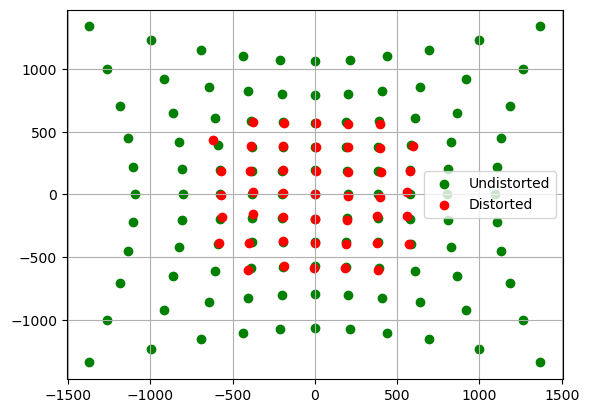

In [15]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
undistorted_points = np.zeros([11, 11, 2])
undistorted_points[:, :, 0] = xx
undistorted_points[:, :, 1] = yy
undistorted_points = (undistorted_points - undistorted_points[5, 5]).reshape([-1, 2])

r_ud = np.sqrt((undistorted_points[:, 0])**2  + (undistorted_points[:, 1])**2).reshape(-1)

x_est = undistorted_points[:, 0]*np.sum([kx[i]*r_ud**j for i, j in enumerate(range(0, num_params+1, step))], axis=0) #+ undistorted_points[:, 0]*undistorted_points[:, 1]*kx[-1]*r_ud
y_est = undistorted_points[:, 1]*np.sum([ky[i]*r_ud**j for i, j in enumerate(range(0, num_params+1, step))], axis=0) #+ undistorted_points[:, 0]*undistorted_points[:, 1]*ky[-1]*r_ud
plt.scatter(x_est, y_est, color='green')
plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='blue')
plt.legend()
plt.grid()

# SAME AS ABOVE
## Using numerical method

In [129]:
# from v3
def polynomial_distortion(params, undistorted_points, distortion_type='both'):
    # distortion_type: radial, tangential, both
    # params is a list of polynomial coefficients
    # undistorted_points is a 2D array of undistorted points
    x, y = undistorted_points.T

    if distortion_type == 'radial_1':
        num_params = len(params)
        # if num_params % 2 == 0 and False:
        #     u = x*(1 + np.sum([params[i] * (x**2+y**2)**(i+1) for i in range(int(num_params/2))], axis=0))
        #     v = y*(1 + np.sum([params[i + int(num_params/2)] * (x**2+y**2)**(i+1) for i in range(int(num_params/2))], axis=0))
        # else:
        #     u = x*(1 + np.sum([params[i] * (x**2+y**2)**(i+1) for i in range(int(num_params))], axis=0))
        #     v = y*(1 + np.sum([params[i] * (x**2+y**2)**(i+1) for i in range(int(num_params))], axis=0))

        u = x*(1 + np.sum([params[i] * (x**2+y**2)**(i+1) for i in range(int(num_params))], axis=0))
        v = y*(1 + np.sum([params[i] * (x**2+y**2)**(i+1) for i in range(int(num_params))], axis=0))
    
    elif distortion_type == 'radial_2': # same as the first method on top but not by linear regression
        num_params = len(params)
        u = x*(params[0] + np.sum([params[i+1] * np.sqrt((x**2+y**2))**(i+1) for i in range(int((num_params-2)/2))], axis=0))
        v = y*(params[int(num_params/2)] + np.sum([params[i+1+int(num_params/2)] * np.sqrt((x**2+y**2))**(i+1) for i in range(int((num_params-2)/2))], axis=0))
    
    elif distortion_type == 'radial_3': # same as radial_2 but x and y share same ks
        num_params = len(params)
        u = x*(params[0] + np.sum([params[i+1] * np.sqrt((x**2+y**2))**(i+1) for i in range(int(num_params-1))], axis=0))
        v = y*(params[0] + np.sum([params[i+1] * np.sqrt((x**2+y**2))**(i+1) for i in range(int(num_params-1))], axis=0))
    
    elif distortion_type == 'tangential':
        u = x + 2*params[0]*x*y + params[1]*(x**2 + y**2 + 2*x**2)
        v = y + params[0]*(x**2 + y**2 + 2*y**2) + 2*params[1]*x*y
    
    elif distortion_type == 'both':
        u = x*(1 + np.sum([params[i] * (x**2+y**2)**(2*i+1) for i in range(len(params)-2)], axis=0)) 
        v = y*(1 + np.sum([params[i] * (x**2+y**2)**(2*i+1) for i in range(len(params)-2)], axis=0))
        u += 2*params[-2]*x*y + params[-1]*(x**2 + y**2 + 2*x**2)
        v += params[-2]*(x**2 + y**2 + 2*y**2) + 2*params[-1]*x*y
    else:
        return None
    return np.column_stack((u, v))

In [108]:
def optimize(params, distortion_type='both'):
    transformed_points = polynomial_distortion(params, undistorted_points, distortion_type=distortion_type)
    error = np.sum((distorted_points[:] - transformed_points[:])**2)
    return error

In [105]:
# Initial guess for the polynomial coefficients
TYPE_OF_DISTORTION = 'radial_2' #[radial_1, radial_2], 
PARAMS_LEN = 6
cost = np.inf
opt = []
for i in range(1000):
    initial_guess = (np.random.rand(PARAMS_LEN) - 0.5)*4

    result = minimize(optimize, initial_guess, TYPE_OF_DISTORTION, method='Nelder-Mead')

    # The result will contain the optimized polynomial coefficients
    optimal_params = result.x
    print(f"{i}- Optimal polynomial coefficients:", optimal_params, result.fun)

    if result.fun < cost:
        cost = result.fun
        opt = result.x

print(f'Optimal coeffs: {opt} with Cost: {cost}')

0- Optimal polynomial coefficients: [ 2.03474706e+00 -4.26215898e-03  3.96953981e-06  1.51673340e+01
 -5.47604768e-02  5.05594213e-05] 5049455.577559623
1- Optimal polynomial coefficients: [-2.38915071e+00  1.27670991e-02 -1.15961449e-05  4.79716538e+00
 -1.46906670e-02  1.36489111e-05] 667524.5485545467
2- Optimal polynomial coefficients: [ 1.45703258e+00 -1.97392435e-03  1.85245560e-06  3.07386998e+00
 -8.07728535e-03  7.56817821e-06] 116074.23122909485
3- Optimal polynomial coefficients: [-5.86375644e+00  2.61479248e-02 -2.38236026e-05  5.35207293e-01
  1.73964392e-03 -1.45403460e-06] 1249967.7931823654
4- Optimal polynomial coefficients: [-5.29464890e+00  2.39343250e-02 -2.17928818e-05 -2.79121439e+00
  1.46377424e-02 -1.33719980e-05] 1429937.5347480092
5- Optimal polynomial coefficients: [ 6.93789725e+00 -2.28771655e-02  2.08602677e-05  9.50503125e-01
  3.38341714e-04 -3.13113343e-07] 887929.4619738475
6- Optimal polynomial coefficients: [-2.65538911e+00  1.37872721e-02 -1.2525741

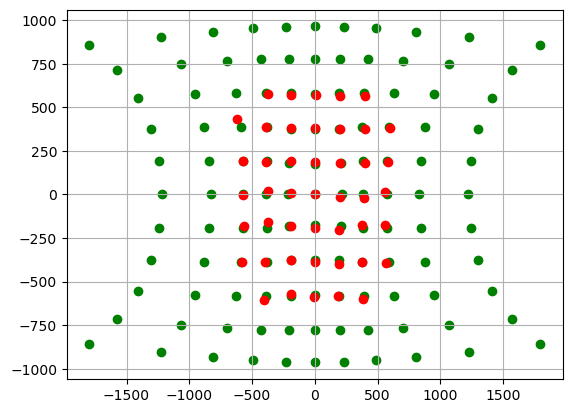

In [106]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
center_cords_undis = np.zeros([11, 11, 2])
center_cords_undis[:, :, 0] = xx
center_cords_undis[:, :, 1] = yy
undistorted_points = (center_cords_undis - center_cords_undis[5, 5]).reshape([-1, 2])
transformed_points = polynomial_distortion(opt, undistorted_points, TYPE_OF_DISTORTION)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='green')

plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='black')


# plt.scatter(transformed_points.reshape([11, 11, 2])[7, 9, 0], transformed_points.reshape([11, 11, 2])[7, 9, 1], color='yellow')
plt.grid()

# SAME AS ABOVE
## coeffs same for x and y cords

In [112]:
# Initial guess for the polynomial coefficients
TYPE_OF_DISTORTION = 'radial_3' #[radial_1, radial_2], 
PARAMS_LEN = 3
cost = np.inf
opt = []
for i in range(1000):
    initial_guess = (np.random.rand(PARAMS_LEN) - 0.5)*4

    result = minimize(optimize, initial_guess, TYPE_OF_DISTORTION, method='Nelder-Mead')

    # The result will contain the optimized polynomial coefficients
    optimal_params = result.x
    print(f"{i}- Optimal polynomial coefficients:", optimal_params, result.fun)

    if result.fun < cost:
        cost = result.fun
        opt = result.x

print(f'Optimal coeffs: {opt} with Cost: {cost}')

0- Optimal polynomial coefficients: [-4.70681506e-01  5.56913066e-03 -5.05585732e-06] 151686.62163482208
1- Optimal polynomial coefficients: [ 1.21899167e+00 -9.28064812e-04  8.91186862e-07] 33743.48965913756
2- Optimal polynomial coefficients: [ 1.00964650e+00 -9.32893859e-05  1.10853739e-07] 32672.800996469578
3- Optimal polynomial coefficients: [ 2.09254929e+00 -4.28708980e-03  3.96578321e-06] 86752.07058936838
4- Optimal polynomial coefficients: [-5.65226272e-01  5.93329893e-03 -5.38959312e-06] 166873.31111834344
5- Optimal polynomial coefficients: [ 2.16774281e+00 -4.57657609e-03  4.23098060e-06] 94946.53799088713
6- Optimal polynomial coefficients: [-2.27751055e+00  1.25248414e-02 -1.14278198e-05] 599414.5638689116
7- Optimal polynomial coefficients: [ 7.00114955e-02  3.49025340e-03 -3.15314679e-06] 82319.91476967474
8- Optimal polynomial coefficients: [ 1.03612844e+00 -2.24858995e-04  2.47491457e-07] 32481.148120705682
9- Optimal polynomial coefficients: [-2.65807412e-01  4.7826

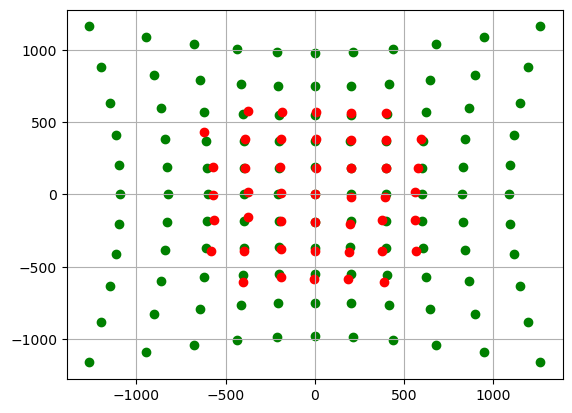

In [113]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
center_cords_undis = np.zeros([11, 11, 2])
center_cords_undis[:, :, 0] = xx
center_cords_undis[:, :, 1] = yy
undistorted_points = (center_cords_undis - center_cords_undis[5, 5]).reshape([-1, 2])
transformed_points = polynomial_distortion(opt, undistorted_points, TYPE_OF_DISTORTION)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='green')

plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='black')


# plt.scatter(transformed_points.reshape([11, 11, 2])[7, 9, 0], transformed_points.reshape([11, 11, 2])[7, 9, 1], color='yellow')
plt.grid()

## RADIAL FIT

$dp_x = udp_x(1 + k_1*r_{ud}^2 + k_2*r_{ud}^4)$

$dp_y = udp_y(1 + k_1*r_{ud}^2 + k_2*r_{ud}^4)$

In [127]:
# Initial guess for the polynomial coefficients
TYPE_OF_DISTORTION = 'radial_1' #[radial_1, radial_2], 
PARAMS_LEN = 2
cost = np.inf
opt = []
for i in range(1000):
    initial_guess = (np.random.rand(PARAMS_LEN) - 0.5)*4

    result = minimize(optimize, initial_guess, TYPE_OF_DISTORTION, method='Nelder-Mead')

    # The result will contain the optimized polynomial coefficients
    optimal_params = result.x
    print(f"{i}- Optimal polynomial coefficients:", optimal_params, result.fun)

    if result.fun < cost:
        cost = result.fun
        opt = result.x

print(f'Optimal coeffs: {opt} with Cost: {cost}')

0- Optimal polynomial coefficients: [-1.30267879e-07  2.72703041e-13] 32332.94962982169
1- Optimal polynomial coefficients: [-1.30259486e-07  2.72685976e-13] 32332.949630533025
2- Optimal polynomial coefficients: [-1.30229722e-07  2.72613419e-13] 32332.94964046802
3- Optimal polynomial coefficients: [-1.30230792e-07  2.72619112e-13] 32332.949651445648
4- Optimal polynomial coefficients: [-1.30275163e-07  2.72716793e-13] 32332.94963432563
5- Optimal polynomial coefficients: [-1.30237259e-07  2.72624792e-13] 32332.94961162527
6- Optimal polynomial coefficients: [-1.30239921e-07  2.72645172e-13] 32332.949668087174
7- Optimal polynomial coefficients: [-1.30253282e-07  2.72652800e-13] 32332.949617794897
8- Optimal polynomial coefficients: [-1.30268210e-07  2.72695555e-13] 32332.949606861443
9- Optimal polynomial coefficients: [-1.30248622e-07  2.72644671e-13] 32332.949607939758
10- Optimal polynomial coefficients: [-1.30268873e-07  2.72702441e-13] 32332.949618627477
11- Optimal polynomial c

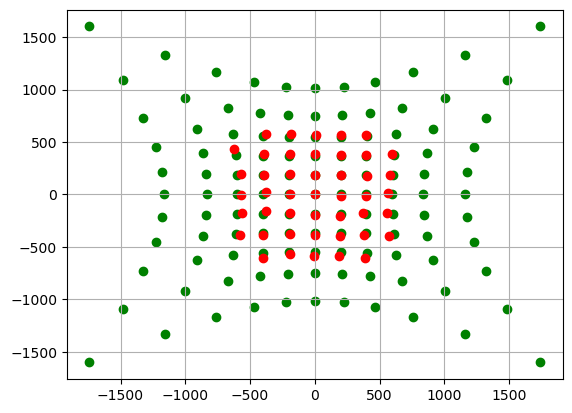

In [128]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
center_cords_undis = np.zeros([11, 11, 2])
center_cords_undis[:, :, 0] = xx
center_cords_undis[:, :, 1] = yy
undistorted_points = (center_cords_undis - center_cords_undis[5, 5]).reshape([-1, 2])
transformed_points = polynomial_distortion(opt, undistorted_points, TYPE_OF_DISTORTION)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='green')

plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='black')


# plt.scatter(transformed_points.reshape([11, 11, 2])[7, 9, 0], transformed_points.reshape([11, 11, 2])[7, 9, 1], color='yellow')
plt.grid()

## TANGENTIAL FIT

$dp_x = udp_x + 2*k_1*udp_x*udp_y + k_2(r_{ud}^2 + 2*udp_x^2)$

$dp_y = udp_y + k_1(r_{ud}^2 + 2*udp_y^2) + 2*k_2*udp_x*udp_y$

In [133]:
# Initial guess for the polynomial coefficients
TYPE_OF_DISTORTION = 'tangential' #[radial_1, radial_2], 
PARAMS_LEN = 2
cost = np.inf
opt = []
for i in range(1000):
    initial_guess = (np.random.rand(PARAMS_LEN) - 0.5)*4

    result = minimize(optimize, initial_guess, TYPE_OF_DISTORTION, method='Nelder-Mead')

    # The result will contain the optimized polynomial coefficients
    optimal_params = result.x
    print(f"{i}- Optimal polynomial coefficients:", optimal_params, result.fun)

    if result.fun < cost:
        cost = result.fun
        opt = result.x

print(f'Optimal coeffs: {opt} with Cost: {cost}')

0- Optimal polynomial coefficients: [-1.42274813e-06 -2.83567359e-06] 33383.82940996531
1- Optimal polynomial coefficients: [-1.42495745e-06 -2.83637945e-06] 33383.82939624695
2- Optimal polynomial coefficients: [-1.42287948e-06 -2.83585320e-06] 33383.82940462252
3- Optimal polynomial coefficients: [-1.42327686e-06 -2.83418408e-06] 33383.82942963702
4- Optimal polynomial coefficients: [-1.42338826e-06 -2.83609191e-06] 33383.82938824448
5- Optimal polynomial coefficients: [-1.42418153e-06 -2.83465614e-06] 33383.829388099824
6- Optimal polynomial coefficients: [-1.43186025e-06 -2.83389090e-06] 33383.83058271546
7- Optimal polynomial coefficients: [-1.42600937e-06 -2.83536773e-06] 33383.82943439553
8- Optimal polynomial coefficients: [-1.42473969e-06 -2.83652714e-06] 33383.82939685288
9- Optimal polynomial coefficients: [-1.42396273e-06 -2.83673430e-06] 33383.829402413794
10- Optimal polynomial coefficients: [-1.42503192e-06 -2.83443821e-06] 33383.82941223975
11- Optimal polynomial coeffi

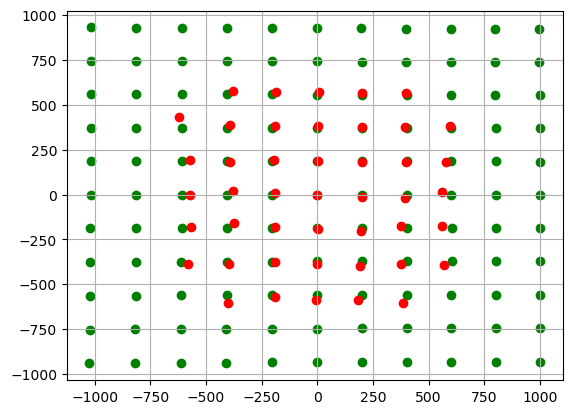

In [134]:
x_axis = [origin[0] - i*x_unit for i in range(-5, 6)]
y_axis = [origin[1] - i*y_unit for i in range(-5, 6)]

xx, yy = np.meshgrid(x_axis, y_axis)
xx, yy = xx[:, ::-1].T, yy.T
center_cords_undis = np.zeros([11, 11, 2])
center_cords_undis[:, :, 0] = xx
center_cords_undis[:, :, 1] = yy
undistorted_points = (center_cords_undis - center_cords_undis[5, 5]).reshape([-1, 2])
transformed_points = polynomial_distortion(opt, undistorted_points, TYPE_OF_DISTORTION)
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], color='green')

plt.scatter(distorted_points[:, 0], distorted_points[:, 1], color='red')
# plt.scatter(undistorted_points[:, 0], undistorted_points[:, 1], color='black')


# plt.scatter(transformed_points.reshape([11, 11, 2])[7, 9, 0], transformed_points.reshape([11, 11, 2])[7, 9, 1], color='yellow')
plt.grid()